In [1]:
 !pip install kaggle

Navigate to https://www.kaggle.com. Then go to the [Account tab of your user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below to upload kaggle.json to your Colab runtime.

In [66]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

 # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [4]:
import os
file_path = 'kaggle.json'  # Path to the file

if os.path.exists(file_path):
    # Move and set permissions for the kaggle.json file
    os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
    os.rename(file_path, os.path.expanduser('~/.kaggle/kaggle.json'))
    os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)
    print(f'File "{file_path}" found and moved to "~/.kaggle/kaggle.json" with appropriate permissions set.')
else:
    print(f'File "{file_path}" not found. Please ensure it is in the correct directory.')

File "kaggle.json" not found. Please ensure it is in the correct directory.


In [5]:
 !kaggle datasets download -d techsash/waste-classification-data

Dataset URL: https://www.kaggle.com/datasets/techsash/waste-classification-data
License(s): CC-BY-SA-4.0
waste-classification-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
 !unzip waste-classification-data.zip

Archive:  waste-classification-data.zip
replace DATASET/TEST/O/O_12568.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## Data Processing

In [7]:
train_dir = 'DATASET/TRAIN'
test_dir = 'DATASET/TEST'

In [8]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [9]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.Resize((256)),
    transforms.ToTensor(),
    transforms.CenterCrop(224),
    transforms.Normalize(
           mean=[0.485, 0.456, 0.406],
           std=[0.229, 0.224, 0.225])
])

In [10]:
trainset = datasets.ImageFolder(train_dir, transform=transform)
testset = datasets.ImageFolder(test_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [11]:
# length of the training and test datasets
print(f"Length of the training dataset: {len(trainset)}")
print(f"Length of the test dataset: {len(testset)}")

Length of the training dataset: 22564
Length of the test dataset: 2513


In [12]:
# label counts
import pandas as pd

# Training data
train_labels = [label for _, label in trainset]
train_labels = pd.Series(train_labels)
print("Training label counts:")
print(train_labels.value_counts())

# Test data
test_labels = [label for _, label in testset]
test_labels = pd.Series(test_labels)
print("Test label counts:")
print(test_labels.value_counts())

Training label counts:
0    12565
1     9999
dtype: int64
Test label counts:
0    1401
1    1112
dtype: int64


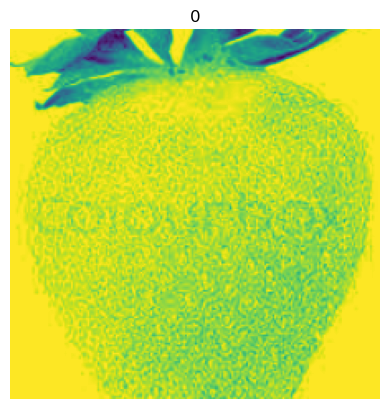

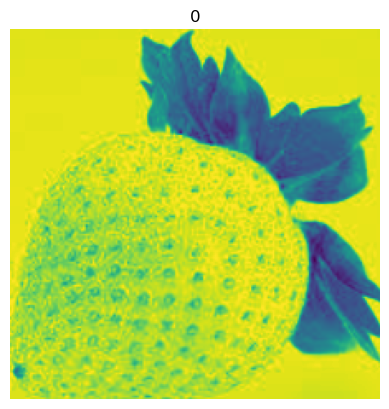

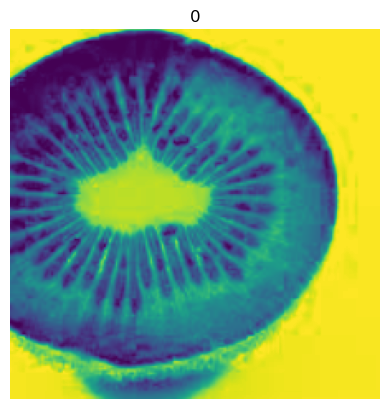

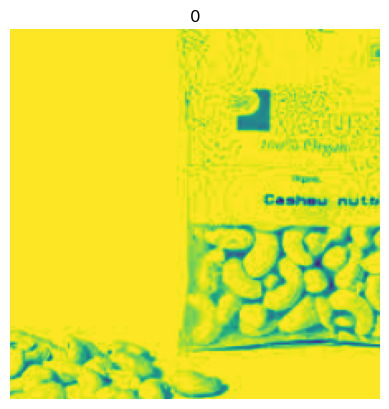

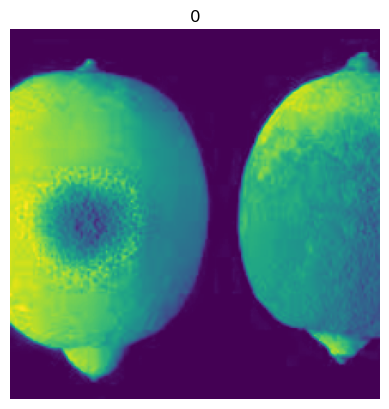

In [13]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(5):
    image, label = trainset[i]
    image = image[0].squeeze()
    # plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)
    plt.show()

In [14]:
image, label = trainset[0]
image.shape

torch.Size([3, 224, 224])

In [15]:
image[0,:]

tensor([[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
        [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
        [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
        ...,
        [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
        [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
        [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]])

## Helper Function

In [16]:
import torch
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn as nn
import torch.nn.functional as F

# Set the random seed for reproducibility
torch.manual_seed(12345)

# Function to calculate the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to track gradients
        for data, target in loader:
            # check if cuda is available
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            output = model(data)  # Forward pass
            _, predicted = torch.max(output.data, 1)  # Get the predicted classes
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Define a function for training.
def train_model(model, loss_func, num_epochs, optimizer, train_loader, val_loader):

  train_loss_log = []
  train_acc_log = []
  test_acc_log = []

  # Move model to GPU if CUDA is available
  if torch.cuda.is_available():
      model = model.cuda()
  tic = time.time()
  for epoch in range(1,num_epochs+1):
    train_loss = 0
    for i, data in enumerate(train_loader):
      x, y = data
      # check if cuda is available
      if torch.cuda.is_available():
        x, y = x.cuda(), y.cuda()
      # get predicted y value from our current model
      pred_y = model(x)
      # calculate the loss
      loss = loss_func(pred_y,y)
      # Zero the gradient of the optimizer
      optimizer.zero_grad()
      # Backward pass: Compute gradient of the loss with respect to model parameters
      loss.backward()
      # update weights
      optimizer.step()
      train_loss += loss.item() * len(x)
    # change the model to evaluation mode to calculate the test loss; We will come back to this later after learning Dropout and Batch Normalization
    train_loss/=len(train_loader)
    train_loss_log.append(train_loss)
    train_acc = calculate_accuracy(train_loader, model)
    val_acc = calculate_accuracy(val_loader, model)
    train_acc_log.append(train_acc)
    test_acc_log.append(val_acc)
    print("Epoch {:2},  Training Loss: {:9.4f}, Training Accuracy: {:9.2f},  Val Accuracy: {:7.2f}".format(epoch, train_loss, train_acc, val_acc))
  toc = time.time()
  print("Elapsed Time : {:7.2f}".format(toc-tic))
  return train_loss_log, train_acc_log, test_acc_log

## Multilayer Perceptron - Three Hidden Layer

In [17]:
# build three hidden layer fully connected net here
class ThreeHiddenLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(ThreeHiddenLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.fc4 = nn.Linear(hidden_dims[2], output_dim)

    def forward(self, x):
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [67]:
# build the model
input_dim = 3*224*224
hidden_dims = [256, 128, 64]
output_dim = 10
epochs = 10
learning_rate = 1e-3
three_hidden_nn = ThreeHiddenLayerNN(input_dim, hidden_dims, output_dim)

# define the loss function and the optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(three_hidden_nn.parameters(), lr=learning_rate)

#train_loss_log, train_acc_log, test_acc_log = train_model(three_hidden_nn, loss_func, epochs, optimizer, trainloader, testloader)

In [ ]:
# Test accuracy of the model
three_hidden_nn_acc = calculate_accuracy(testloader, three_hidden_nn)
three_hidden_nn_acc

In [ ]:
# Compute the number of parameters
num_params_three_hidden_nn = count_parameters(three_hidden_nn)
num_params_three_hidden_nn

## Vision Transformer (ViT)

## Convolutional Neural Networks (CNN)

### CNN without Normal Batch

In [ ]:
class ConvolutionalNN(nn.Module):
    def __init__(self):
        super(ConvolutionalNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # First convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Second convolutional layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Third convolutional layer
        self.pool = nn.MaxPool2d(2, 2) # Pooling layer
        self.dropout = nn.Dropout(0.5) # Dropout layer to prevent overfitting
        self.fc1 = nn.Linear(128 * 28 * 28, 512) # Fully connected layer
        self.fc2 = nn.Linear(512, 2) # Output layer, 2 classes: Organic, Recyclable

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = torch.flatten(x, 1) # Flatten the features into a vector

        x = self.dropout(x)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Initialize the model, loss function, and optimizer
conv_nn = ConvolutionalNN()
epoch = 10
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv_nn.parameters(), lr=0.001)

# Train the model
train_loss_log, train_acc_log, test_acc_log = train_model(conv_nn, loss_func, epoch, optimizer, trainloader, testloader)

In [19]:
class ConvolutionalNN(nn.Module):
    def __init__(self):
        super(ConvolutionalNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # First convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Second convolutional layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Third convolutional layer
        self.pool = nn.MaxPool2d(2, 2) # Pooling layer
        self.dropout = nn.Dropout(0.5) # Dropout layer to prevent overfitting
        self.fc1 = nn.Linear(128 * 28 * 28, 512) # Fully connected layer
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)# Output layer, 2 classes: Organic, Recyclable

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = torch.flatten(x, 1) # Flatten the features into a vector

        x = self.dropout(x)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Final layer without ReLU activation
        x = self.fc3(x)
        return x

In [20]:
# Initialize the model, loss function, and optimizer
conv_nn = ConvolutionalNN()
epoch = 10
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv_nn.parameters(), lr=0.001)

# Train the model
train_loss_log, train_acc_log, test_acc_log = train_model(conv_nn, loss_func, epoch, optimizer, trainloader, testloader)

Epoch  1,  Training Loss:   28.5515, Training Accuracy:     84.76,  Val Accuracy:   88.34
Epoch  2,  Training Loss:   22.2572, Training Accuracy:     87.36,  Val Accuracy:   88.74
Epoch  3,  Training Loss:   19.7985, Training Accuracy:     89.21,  Val Accuracy:   87.39
Epoch  4,  Training Loss:   16.4625, Training Accuracy:     93.65,  Val Accuracy:   88.90
Epoch  5,  Training Loss:   11.5957, Training Accuracy:     96.33,  Val Accuracy:   88.50
Epoch  6,  Training Loss:    7.0260, Training Accuracy:     97.46,  Val Accuracy:   88.78
Epoch  7,  Training Loss:    3.7420, Training Accuracy:     98.90,  Val Accuracy:   86.51
Epoch  8,  Training Loss:    2.3721, Training Accuracy:     99.50,  Val Accuracy:   90.17
Epoch  9,  Training Loss:    2.2849, Training Accuracy:     99.78,  Val Accuracy:   88.30
Epoch 10,  Training Loss:    1.3384, Training Accuracy:     99.15,  Val Accuracy:   88.34
Elapsed Time : 11466.03


### CNN with batch normalization 

In [30]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.activation = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(128)

        # Correct the number of input features to match the output from the convolutional layers
        self.fc1 = nn.Linear(28*28*128, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)  # Assuming 10 classes for CIFAR-10

    def forward(self, x):
        x = self.pool(self.activation(self.batch_norm1(self.conv1(x))))
        x = self.pool(self.activation(self.batch_norm2(self.conv2(x))))
        x = self.pool(self.activation(self.batch_norm3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x


In [31]:
# Initialize the model, loss function, and optimizer
conv_nn = CNN()
epoch = 10
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv_nn.parameters(), lr=0.001)

# Train the model
train_loss_log, train_acc_log, test_acc_log = train_model(conv_nn, loss_func, epoch, optimizer, trainloader, testloader)

Epoch  1,  Training Loss:   44.5858, Training Accuracy:     82.15,  Val Accuracy:   85.20
Epoch  2,  Training Loss:   26.1140, Training Accuracy:     82.40,  Val Accuracy:   83.92
Epoch  3,  Training Loss:   24.6093, Training Accuracy:     82.89,  Val Accuracy:   81.42
Epoch  4,  Training Loss:   23.4606, Training Accuracy:     85.21,  Val Accuracy:   85.48
Epoch  5,  Training Loss:   22.4397, Training Accuracy:     86.28,  Val Accuracy:   85.75
Epoch  6,  Training Loss:   21.7424, Training Accuracy:     86.83,  Val Accuracy:   86.67
Epoch  7,  Training Loss:   21.0926, Training Accuracy:     86.05,  Val Accuracy:   85.44
Epoch  8,  Training Loss:   20.3269, Training Accuracy:     87.58,  Val Accuracy:   86.79
Epoch  9,  Training Loss:   20.0095, Training Accuracy:     88.04,  Val Accuracy:   90.93
Epoch 10,  Training Loss:   19.7434, Training Accuracy:     87.32,  Val Accuracy:   90.93
Elapsed Time : 14194.63


In [33]:
# Test accuracy of the model
conv_nn_acc = calculate_accuracy(testloader, conv_nn)
conv_nn_acc

91.00676482292081

In [51]:
# Compute the number of parameters
num_params_conv_nn = count_parameters(conv_nn)
num_params_conv_nn

25817218

### CNN with Data Augmentation 

In [36]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flips the image horizontally
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Mild color variations
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),  # Small rotations, translations, and scale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [37]:
trainset = datasets.ImageFolder(train_dir, transform=transform)
testset = datasets.ImageFolder(test_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

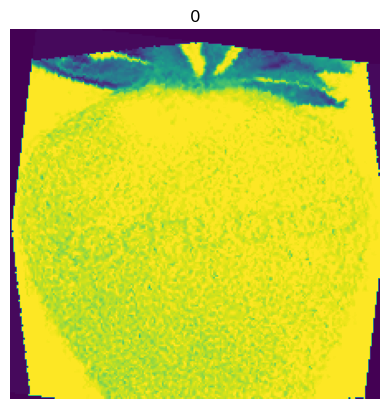

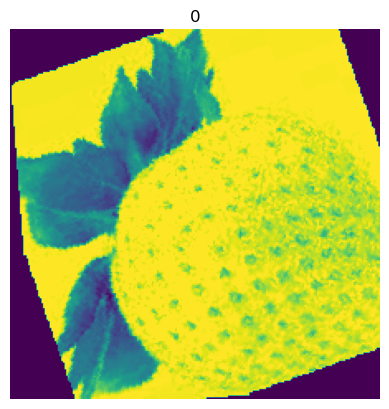

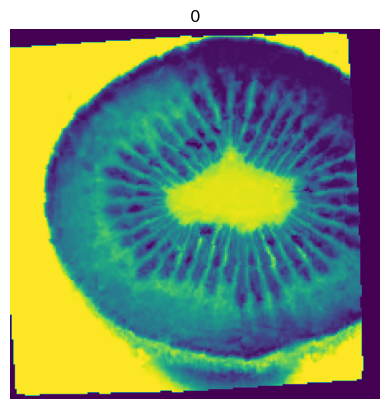

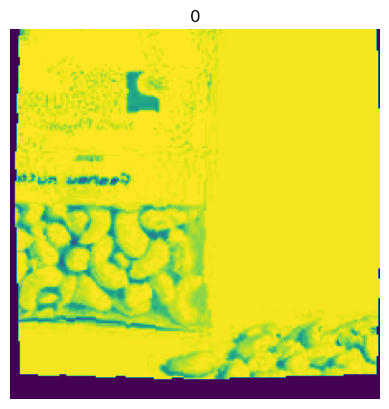

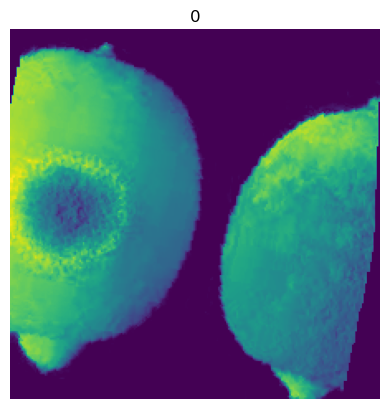

In [38]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(5):
    image, label = trainset[i]
    image = image[0].squeeze()
    # plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)
    plt.show()

In [39]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.activation = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(128)

        # Correct the number of input features to match the output from the convolutional layers
        self.fc1 = nn.Linear(28*28*128, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(self.activation(self.batch_norm1(self.conv1(x))))
        x = self.pool(self.activation(self.batch_norm2(self.conv2(x))))
        x = self.pool(self.activation(self.batch_norm3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

In [41]:
# Initialize the model, loss function, and optimizer
conv_nn_aug = CNN()
epoch = 10
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv_nn_aug.parameters(), lr=0.001)

# Train the model
train_loss_log, train_acc_log, test_acc_log = train_model(conv_nn_aug, loss_func, epoch, optimizer, trainloader, testloader)

Epoch  1,  Training Loss:   41.0220, Training Accuracy:     82.69,  Val Accuracy:   87.11
Epoch  2,  Training Loss:   26.4257, Training Accuracy:     83.54,  Val Accuracy:   86.63
Epoch  3,  Training Loss:   24.7047, Training Accuracy:     84.54,  Val Accuracy:   85.87
Epoch  4,  Training Loss:   23.6708, Training Accuracy:     84.65,  Val Accuracy:   86.91
Epoch  5,  Training Loss:   22.7934, Training Accuracy:     85.65,  Val Accuracy:   85.20
Epoch  6,  Training Loss:   22.3824, Training Accuracy:     84.53,  Val Accuracy:   82.37
Epoch  7,  Training Loss:   21.2460, Training Accuracy:     86.60,  Val Accuracy:   87.82
Epoch  8,  Training Loss:   20.6534, Training Accuracy:     87.26,  Val Accuracy:   88.10
Epoch  9,  Training Loss:   19.8008, Training Accuracy:     87.96,  Val Accuracy:   89.06
Epoch 10,  Training Loss:   19.4112, Training Accuracy:     87.67,  Val Accuracy:   89.61
Elapsed Time : 12599.09


In [42]:
# Test accuracy of the model
conv_nn_aug_acc = calculate_accuracy(testloader, conv_nn_aug)
conv_nn_aug_acc

89.53442101074413

### CNN with another data augmentation 

In [46]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flips the image horizontally
    transforms.RandomRotation(15),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Mild color variations
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),  # Small rotations, translations, and scale
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [47]:
trainset = datasets.ImageFolder(train_dir, transform=transform)
testset = datasets.ImageFolder(test_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

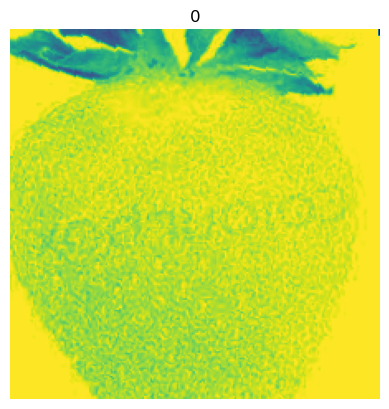

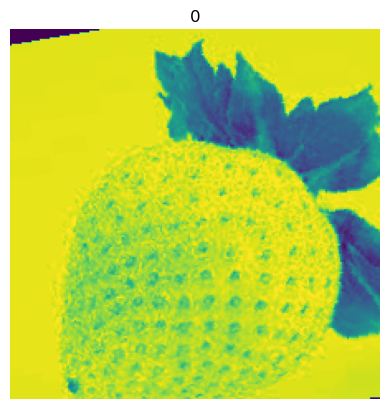

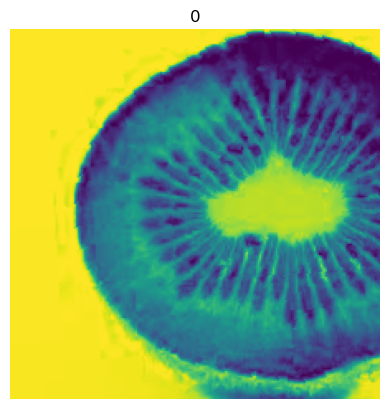

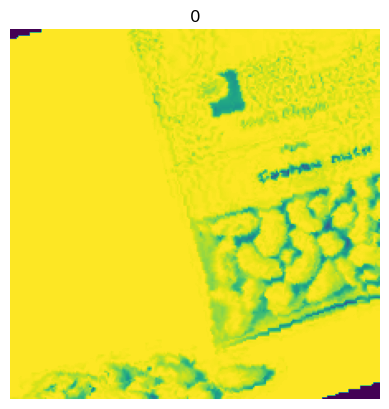

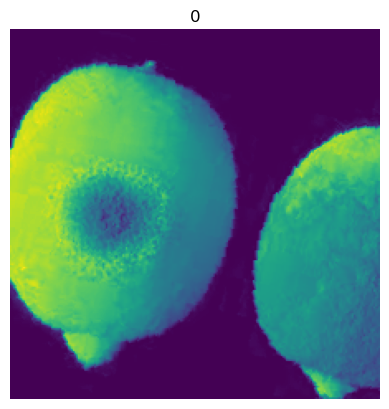

In [48]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(5):
    image, label = trainset[i]
    image = image[0].squeeze()
    # plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)
    plt.show()

In [49]:
# Initialize the model, loss function, and optimizer
conv_nn_aug = CNN()
epoch = 10
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv_nn_aug.parameters(), lr=0.001)

# Train the model
train_loss_log, train_acc_log, test_acc_log = train_model(conv_nn_aug, loss_func, epoch, optimizer, trainloader, testloader)

Epoch  1,  Training Loss:   38.2495, Training Accuracy:     83.91,  Val Accuracy:   85.75
Epoch  2,  Training Loss:   24.3428, Training Accuracy:     84.26,  Val Accuracy:   85.79
Epoch  3,  Training Loss:   22.6470, Training Accuracy:     86.29,  Val Accuracy:   88.30
Epoch  4,  Training Loss:   22.2210, Training Accuracy:     87.18,  Val Accuracy:   88.38
Epoch  5,  Training Loss:   20.7484, Training Accuracy:     87.35,  Val Accuracy:   88.42
Epoch  6,  Training Loss:   19.9199, Training Accuracy:     88.46,  Val Accuracy:   88.06
Epoch  7,  Training Loss:   18.7134, Training Accuracy:     89.15,  Val Accuracy:   88.02
Epoch  8,  Training Loss:   18.6827, Training Accuracy:     89.04,  Val Accuracy:   89.30
Epoch  9,  Training Loss:   17.9605, Training Accuracy:     89.63,  Val Accuracy:   90.37
Epoch 10,  Training Loss:   17.2603, Training Accuracy:     88.72,  Val Accuracy:   87.39
Elapsed Time : 12105.40


In [50]:
# Test accuracy of the model
conv_nn_aug_acc = calculate_accuracy(testloader, conv_nn_aug)
conv_nn_aug_acc

87.5049741345006

In [52]:
# Compute the number of parameters
num_params_conv_nn_aug = count_parameters(conv_nn_aug)
num_params_conv_nn_aug

25817218

### CNN with dropout, batchnormalization, and data augmentation 

In [54]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.1),  # Low probability vertical flip
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomErasing(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [55]:
trainset = datasets.ImageFolder(train_dir, transform=transform)
testset = datasets.ImageFolder(test_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

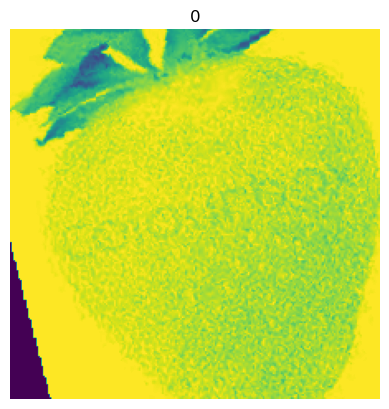

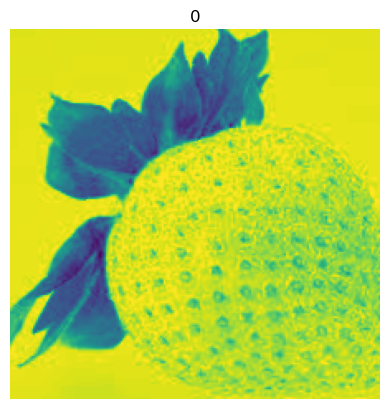

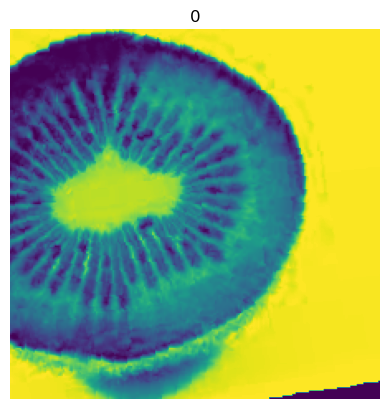

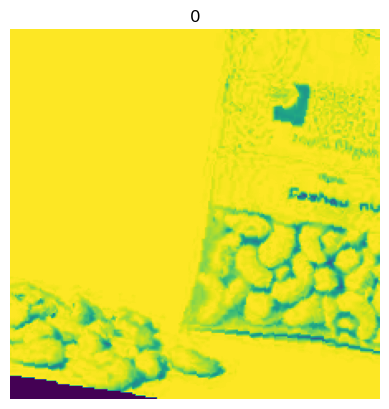

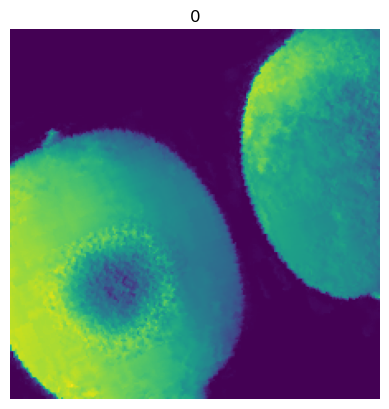

In [56]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(5):
    image, label = trainset[i]
    image = image[0].squeeze()
    # plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)
    plt.show()

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

class AdvancedCNN(nn.Module):
    def __init__(self):
        super(AdvancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Added extra layer
        self.pool = nn.MaxPool2d(2, 2)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.batch_norm4 = nn.BatchNorm2d(256)  # Added batch norm for new layer
        self.fc1 = nn.Linear(256 * 14 * 14, 512)  # Adjusted for new layer size
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2) 
        
    def forward(self, x):
        x = self.pool(self.activation(self.batch_norm1(self.conv1(x))))
        x = self.pool(self.activation(self.batch_norm2(self.conv2(x))))
        x = self.pool(self.activation(self.batch_norm3(self.conv3(x))))
        x = self.pool(self.activation(self.batch_norm4(self.conv4(x))))  # Forward through new layer
        x = torch.flatten(x, 1)
        x = self.dropout(self.activation(self.fc1(x)))
        x = self.dropout(self.activation(self.fc2(x)))
        x = self.fc3(x)
        return x

model = AdvancedCNN()


In [63]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time

def advanced_train(model, loss_func, num_epochs, optimizer, train_loader, val_loader):
    # Initialize the learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

    # Add gradient clipping directly inside the optimizer step loop
    for epoch in range(1, num_epochs + 1):
        model.train()
        for i, data in enumerate(train_loader):
            x, y = data
            if torch.cuda.is_available():
                x, y = x.cuda(), y.cuda()
            optimizer.zero_grad()
            pred_y = model(x)
            loss = loss_func(pred_y, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        # Existing function for training and calculating accuracy
        train_loss_log, train_acc_log, test_acc_log = train_model(model, loss_func, 1, optimizer, train_loader, val_loader)
        
        # After each epoch, use the last validation accuracy logged to adjust the learning rate
        last_val_acc = test_acc_log[-1]
        scheduler.step(last_val_acc)

        print(f"Adjusted Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

    return train_loss_log, train_acc_log, test_acc_log

# Setup and call this function with your model and parameters
loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
train_loader = trainloader
val_loader = testloader

# Call the advanced training function
train_loss_log, train_acc_log, test_acc_log = advanced_train(model, loss_func, num_epochs, optimizer, train_loader, val_loader)


Epoch  1,  Training Loss:   28.4106, Training Accuracy:     84.80,  Val Accuracy:   84.32
Elapsed Time : 1448.63
Adjusted Learning Rate: 0.001000
Epoch  1,  Training Loss:   24.3114, Training Accuracy:     86.83,  Val Accuracy:   90.93
Elapsed Time : 1459.20
Adjusted Learning Rate: 0.001000
Epoch  1,  Training Loss:   22.7496, Training Accuracy:     87.58,  Val Accuracy:   87.74
Elapsed Time : 1453.42
Adjusted Learning Rate: 0.001000
Epoch  1,  Training Loss:   21.0715, Training Accuracy:     87.93,  Val Accuracy:   87.82
Elapsed Time : 1477.05
Adjusted Learning Rate: 0.001000
Epoch  1,  Training Loss:   20.5532, Training Accuracy:     87.26,  Val Accuracy:   88.94
Elapsed Time : 1434.44
Adjusted Learning Rate: 0.001000
Epoch  1,  Training Loss:   20.0595, Training Accuracy:     87.90,  Val Accuracy:   87.31
Elapsed Time : 1409.12
Adjusted Learning Rate: 0.001000
Epoch  1,  Training Loss:   19.0566, Training Accuracy:     87.68,  Val Accuracy:   88.74
Elapsed Time : 1370.44
Adjusted Le

In [64]:
# Test accuracy of the model
adv_conv_nn_aug_acc = calculate_accuracy(testloader, model)
adv_conv_nn_aug_acc

91.32510943095902

In [65]:
# Compute the number of parameters
num_params_adv_conv_nn_aug = count_parameters(model)
num_params_adv_conv_nn_aug

26145922